<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_pytorch_DL/blob/main/20220908_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ResNet을 이용해 CIFAR-10 데이터 분류
 - 데이터셋 : 10가지 사물과 동물
 - 문제유형 : 분류
 - 평가지표 : CE 오차

## ResNet
 - CNN 중에서 가장 많이 쓰이는 모델
 - VGG 모델은 층을 많이 쌓으면 입력층에 가까운 가중치들의 기울기가 0에 가까워져(기울기 소실) 가중치가 더이상 업데이트 되지 않음

  > VGG는 합성곱층을 19층 이상으로 쌓을 수 없음

 - ResNet은 스킵 커넥션을 이용해 기울기 소실문제 해결
 
  > ResNet은 합성곱층을 100층 까지 쌓을 수 있음


 - CNN에서 하나의 층 : 한번의 특징 추출
 - CNN은 여러층을 쌓아 많은 특징 확보
 - 특징을 조합해 이미지 분류
 - CNN에는 층하나를 거칠때 마다 픽셀 하나가 원본 이미지에서 차지하는 영역이 넓어짐
 - 합성곱을 거치면서 이미지 크기가 줄어듦
 - 특징 맵에서의 픽셀 하나는 이전층의 여러 픽셀 정보를 압축한것
 
  > 층을 무한정 쌓으면 이미지 전체가 픽셀 하나로 압축되므로 특징을 조합해 분류할 때 불리하게 작용


 - 기울기 소실
  
  > 오차 역전파를 통해 가중치 업데이트할 때, 신경망의 앞쪽(입력층 쪽)에 올수록 신경망의 뒷쪽(출력층 쪽)의 기울기가 누적되어 곱해짐


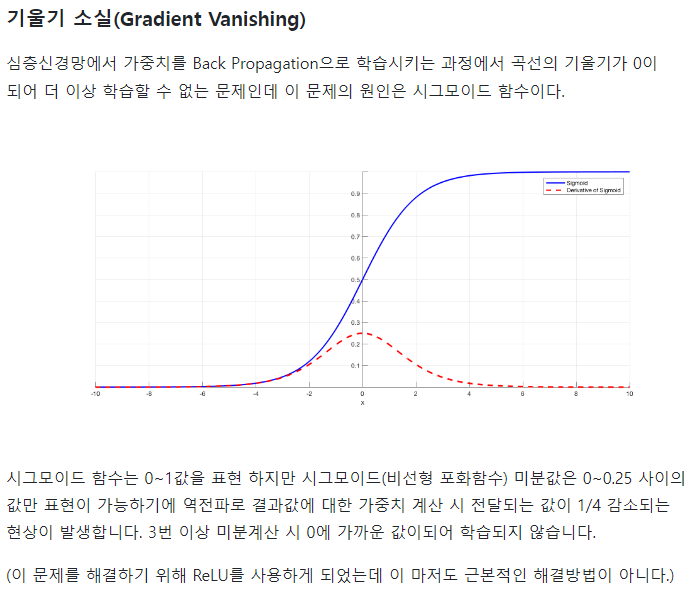

 - 기울기 소실문제 해결을 위한 ResNet의 스킵 커넥션
 
 > 자기 자신을 미분하면 1이 나오기 때문에 신경망의 출력 부분에 입력(자기 자신)을 더하는 방식으로 기울기를 최소 1로 확보하는 기법

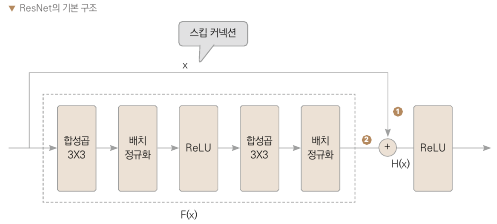

## 배치 정규화
 - 모델을 학습할 때 데이터를 배치단위로 나눠서 학습
 - 배치 간의 데이터 분포가 다르면 문제발생
 - 모델의 입력으로 들어오는 배치의 분포를 일정하게 하는 방법

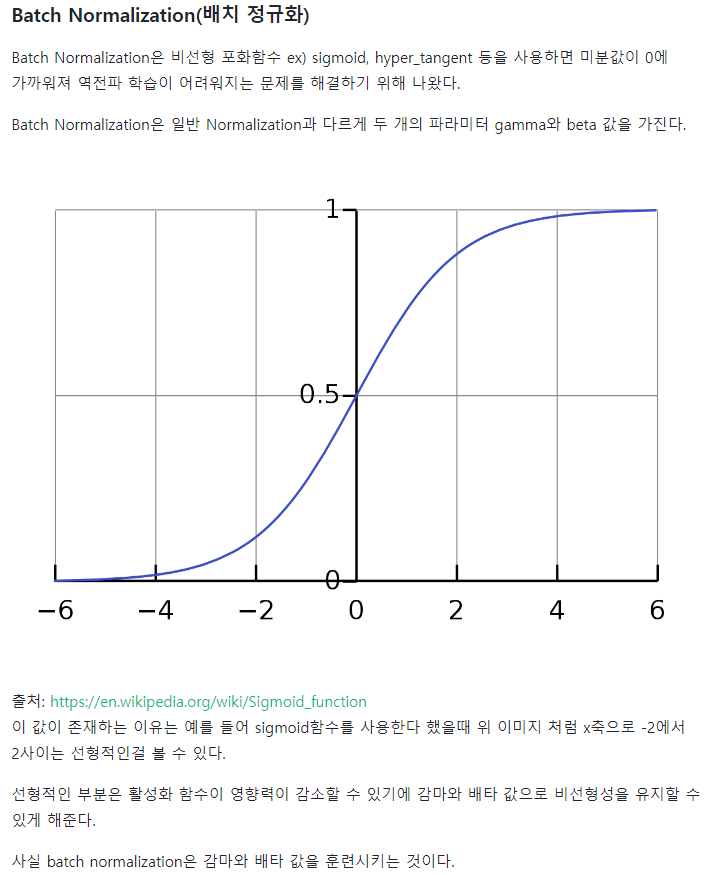

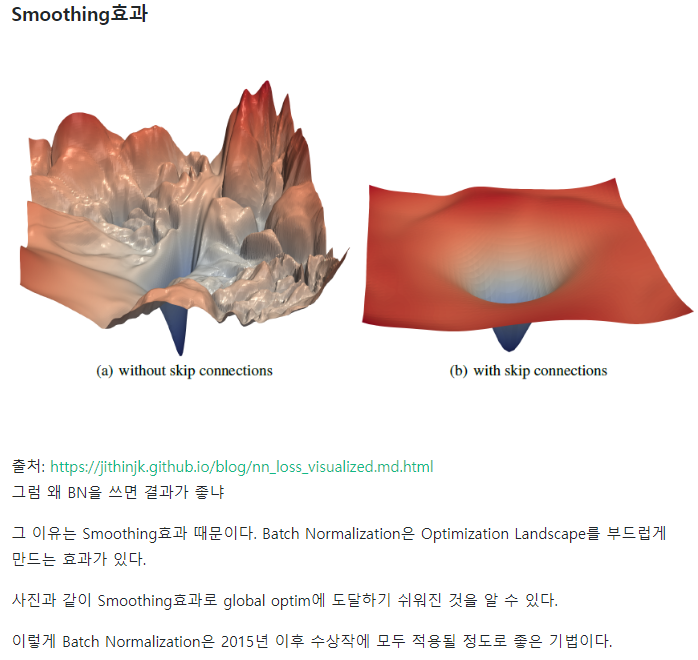

## 기본 블록 정의하기
 - ResNet에서는 블록의 입력이 출력에 그대로 더해져야하기 때문에 데이터 흐름이 일반적이지 않다

  > 따라서 nn.Module 이용

 - 합성곱 은닉층을 통해 만들어진 결과(특징맵)는 채널이 많게는 64~256개 까지 늘어남
 - 은닉층의 결과값(64~256개 채널)에 입력값(RGB, 3채널)을 더하려니 채널 숫자가 맞지 않음
 - 따라서, 스킵커넥션을 위해, 원본이미지의 특징을 손상시키지 않도록 1X1 합성곱을 이용해 채널의 숫자를 맞춰줌
 - 스킵 커넥션에서 입력값과 합성곱의 결과를 더해주려면 채널수를 맞춰야하므로 1x1합성곱을 사용하게 되며 이를 다운샘플 이라함

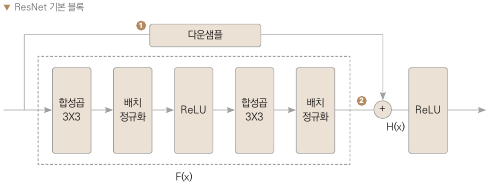

In [33]:
# ResNet 기본 합성곱 블록 : F(x)

import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()

        # 합성곱층 정의
        self.c1 = nn.Conv2d(in_channels, out_channels,
                            kernel_size=kernel_size, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels,
                            kernel_size=kernel_size, padding=1)
        
        self.downsample = nn.Conv2d(in_channels, out_channels,  # 채널은 합성곱층의 out채널과 맞추고,
                                    kernel_size=1)              # 커널 사이즈는 원본이미지 특징 유지를위해 1X1

        # 배치 정규화 층 정의
        self.bn1 = nn.BatchNorm2d(num_features=out_channels) # 앞에 오는 합성곱층의 출력 채널만큼의 특징을 갖음
        self.bn2 = nn.BatchNorm2d(num_features=out_channels) # 앞에 오는 합성곱층의 출력 채널만큼의 특징을 갖음
        
        self.relu =nn.ReLU()


    # 기본 합성곱 블록의 순전파
    def forward(self, x):
        # (신경망을 거치기 전에) 스킵 커넥션을 위해 "초기 입력 저장"
        x_ = x

        # ResNet 기본 블록에서 F(x) 부분
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)

        # 합성곱의 결과와 입력의 채널 수를 맞춤
        x_ = self.downsample(x_)

        # 합성곱층의 결과와 저장해놨던 입력값을 더해줌
        x += x_
        x = self.relu(x)

        return x

## ResNet 모델 정의하기

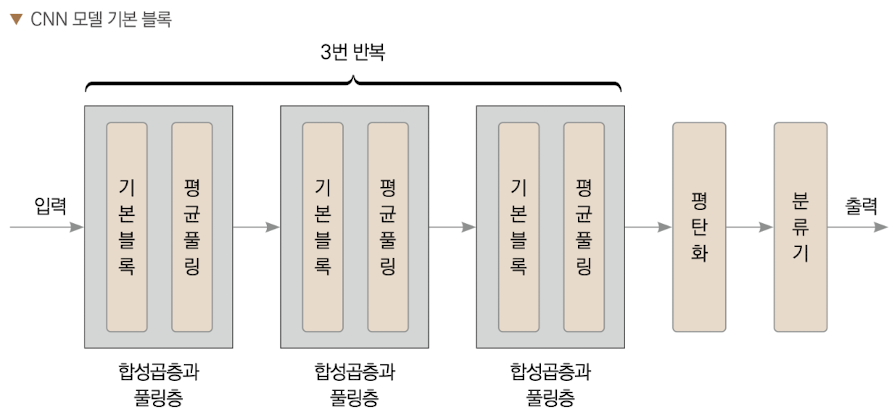

 - 위에서 만든 합성곱 기본블록을 3번(+ 각 블록마다 평균풀링)
 - 기본블록을 몇 번 쌓을지는 이미지의 크기에 따라 결정
 - 풀링층(최대/평균)을 거칠때마다 이미지의 가로,세로 길이가 절반이 됨
  
  > 32X32 → 16X16 → 8X8 → 4X4

 - 최대/평균 풀링 모두 정보 손실은 발생하지만, 평균풀링은 모든 픽셀의 정보를 담을 수 있기에 조금 더 유리

In [34]:
# ResNet 모델 정의하기

class ResNet(nn.Module):
    def __init__(self, num_classes=10): # 몇개의 클래스로 분류할지 파라미터로 정의
        super().__init__() # nn.Module의 모든 속성 및 메서드를 받아옴

        # 기본 블록
        self.b1 = BasicBlock(in_channels=3, out_channels=64)
        self.b2 = BasicBlock(in_channels=64, out_channels=128)
        self.b3 = BasicBlock(in_channels=128, out_channels=256)

        # 평균 풀링
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # 분류기
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

        # 활성화 함수 층
        self.relu = nn.ReLU()

    # ResNet의 순전파 정의
    def forward(self, x):

        # 기본 블록과 풀링층 통과
        x = self.b1(x)      # [32, 3, 32, 32] → [32, 64, 32, 32] → [32, 64, 32, 32]
        x = self.pool(x)    # [32, 64, 32, 32] → [32, 64, 16, 16]
        x = self.b2(x)      # [32, 64, 16, 16] → [32, 128, 16, 16] → [32, 128, 16, 16]
        x = self.pool(x)    # [32, 128, 16, 16] → [32, 128, 8, 8]
        x = self.b3(x)      # [32, 128, 8, 8] → [32, 256, 8, 8] → [32, 256, 8, 8]
        x = self.pool(x)    # [32, 256, 8, 8] → [32, 256, 4, 4]

        # 분류기의 입력으로 사용하기 위한 평탄화
        # x = x.reshape(x.shape[0], -1) # x.shape[0] : 배치크기
        x = torch.flatten(x, start_dim=1)   # [32, 256, 4, 4] → [32, 4096]

        # 분류기로 예측값 출력
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

## 모델 학습하기

 ### 데이터 전처리 정의

In [35]:
# 데이터 전처리 정의
import tqdm

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([RandomCrop((32, 32), padding=4),
                      RandomHorizontalFlip(p=0.5),
                      ToTensor(),
                      Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))])

### 데이터 불러오기

In [36]:
# 데이터 불러오기

# 데이터셋 정의
training_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

# 데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 모델 정의하기

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(num_classes=10)
model.to(device)

ResNet(
  (b1): BasicBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 학습 루프 정의

In [ ]:
lr = 1e-4   # 학습률 정의
optim = Adam(model.parameters(), lr=lr) # 옵티마이저 정의

for epoch in range(10):
    # for data, label in tqdm.tqdm(train_loader):
    iterator = tqdm.tqdm(train_loader)  # 이후 set_description() 메서드를 활용하기 위함
    for data, label in iterator:
        # gpu로 보내기
        data = data.to(device)
        label = label.to(device)

        optim.zero_grad()   # 가중치의 기울기 초기화

        preds = model(data) # 모델의 예측값

        criterion = nn.CrossEntropyLoss() # 손실함수 정의
        loss = criterion(preds, label) # 예측값과 실제정답(레이블)의 손실 계산
        loss.backward() # 역전파 : 가중치의 기울기 계산/저장
        optim.step()    # 가중치 업데이트

        # epoch마다 progress확인을 위해 tqdm모듈 사용
        # tqdm모듈을 활용하여 progress마다 설명을 붙일 수 있다
        iterator.set_description(f'epoch:{epoch+1} loss:{loss.item()}')

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ResNet.pth')

epoch:10 loss:0.3826817274093628:  37%|███▋      | 580/1563 [00:17<00:30, 32.52it/s]

## 모델 성능 평가하기

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ResNet.pth', map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in test_loader():
        data.to(device)
        label.to(device)

        output = model(data)
        preds = output.max(1)[1] # 배치크기내에서 

 - 기본 CNN 모델(100번의 iteration)의 정확도 보다 30번 iteration의 ResNet이 정확도 좋음
 - 학습률, 반복횟수등의 조정보다 성능 좋은 모델 선택하는 것이 정확도에 더 큰 영향
 - 반면에 아무리 뛰어난 구조의 ResNet이라고 하더라도 사전학습된 모델을 전이 학습 하는것이 더 뛰어난 성능

  > 정확도 비교
  
  > 사전학습된 모델을 전이학습한 모델 >> ResNet모델 >> 기본 CNN모델